In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import time # 수행시간
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_graphviz
import graphviz
from sklearn import tree

from sklearn.datasets import make_classification

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import (VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,
                                ExtraTreesClassifier, GradientBoostingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import xgboost as xgb # python wrapper
from xgboost import XGBClassifier  # sklearn wrapper
from lightgbm import LGBMClassifier

import pickle                  # 모델 저장
import matplotlib as mpl       # 한글깨짐
import matplotlib.font_manager as fm
import matplotlib.font_manager 

## 분류에서 feature_importance_보여주는 것이고, RFECV 단계별 수행하는 것

In [ ]:
### Recursive Feature Elimination
* feature 중요도가 낮은 속성들은 차례로 제거해 가면서 반복적으로 학습/평가를 수행하여 최적 feature 추출
* 수행시간이 길고, 낮은 속성들을 제거해 나가는 메커니즘이 정확한 Feature selection을 찾는 목표에 정확히 부합하지 않을 수 있음

Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.


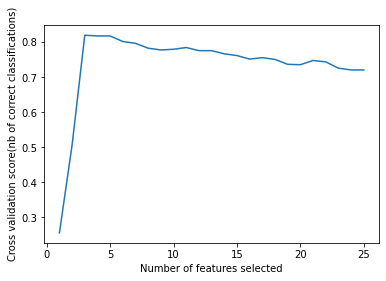

In [2]:
# Feature 25개 데이터 1000개 생성
X, y = make_classification(n_samples=1000, n_features=25, n_redundant=2, n_informative=3,
                             n_classes=8, n_repeated=0, n_clusters_per_class=1,random_state=0)
svc = SVC(kernel = "linear")

# RFECV Feature들을 반복적으로 제거해 가면서 학습/평가 수행, step 단계별 feature 제거
rfecv = RFECV(estimator = svc, step = 1, cv=StratifiedKFold(2), scoring='accuracy', verbose=2)
rfecv.fit(X,y)

print(f"Optimal number of features {rfecv.n_features_}")
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score(nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [ ]:
# 10000  시간걸림
# build a classification task using 3 informative features
X, y = make_classification(n_samples=10000, n_features=25, n_redundant=2, n_informative=3,
                             n_classes=8, n_repeated=0, n_clusters_per_class=1,random_state=0)
svc = SVC(kernel = "linear")
rfecv = RFECV(estimator = svc, step = 1, cv=StratifiedKFold(2), scoring='accuracy', verbose=2)
rfecv.fit(X,y)

print(f"Optimal number of features {rfecv.n_features_}")
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score(nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### selectFromModel # utility
### 회귀에서는 RFECV사용할 수 없고, 회귀계수coef_로 판단할 수 있다

In [3]:
from sklearn.datasets import load_diabetes
diabetes=load_diabetes()
X,y = diabetes.data, diabetes.target
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

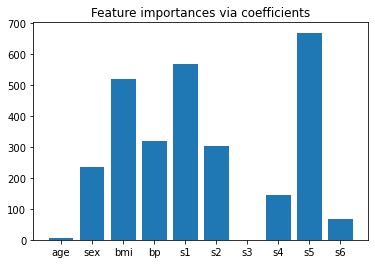

threshold : 521.7485426067491
Features selected by SelectFromModel : ['bmi' 'bp' 's1' 's2' 's5']


In [4]:
from sklearn.linear_model import LassoCV

lasso = LassoCV().fit(X,y)
importance = np.abs(lasso.coef_) # 회귀계수 절대값으로 변환
feature_names = np.array(diabetes.feature_names)
plt.bar(height = importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

from sklearn.feature_selection import SelectFromModel
threshold = np.sort(importance)[-3] + 0.01
print(f"threshold : {threshold}")

# SelectFromModel에서 threshold는 중앙값 median, 1.5*median
sfm = SelectFromModel(lasso, threshold='median').fit(X,y)
# sfm = SelectFromModel(lasso, threshold=threshold).fit(X,y)
print(f"Features selected by SelectFromModel : {feature_names[sfm.get_support()]}")

In [5]:
# RFECV 분류에만 회귀에는 error
# rfecv = RFECV(estimator = lasso, step = 1, cv=StratifiedKFold(2), scoring='accuracy', verbose=2)
# rfecv.fit(X,y) # Classification metrics can't handle a mix of multiclass and continuous targets

## Permutation importance
* 특정피처 값 변조했을때 성능이 얼마나 저하되는지 기준 -> 피처의 중요도 선정
* 수행시간이 오래걸림, 
* https://scikit-learn.org/stable/modules/permutation_importance.html

In [6]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

from sklearn.datasets import load_diabetes
diabetes=load_diabetes()
X,y = diabetes.data, diabetes.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

model = Ridge(alpha=1e-2).fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"r2_score(y_test, y_pred) : {r2_score(y_test, y_pred)}")

r2_score(y_test, y_pred) : 0.4276191347741459


In [7]:
# 아래 r2값을 위 종합 r2값과 비교
from sklearn.inspection import permutation_importance 
# 학습데이터가 아닌 검증데이터를 넣어야 한다 # feature당 shuffle횟수 n_repeats
r = permutation_importance(model, X_test, y_test, n_repeats = 30, random_state = 0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 *r.importances_std[i] >0:
        print(f'{diabetes.feature_names[i]}     {np.round(r.importances_mean[i], 4)}  +/-  {np.round(r.importances_std[i], 5)}')

s5     0.3293  +/-  0.07265
bmi     0.2045  +/-  0.04632
s1     0.1548  +/-  0.03869
bp     0.0713  +/-  0.03123
sex     0.0523  +/-  0.01883
s2     0.0503  +/-  0.02385


In [8]:
r.importances_mean

array([-0.00236441,  0.05228045,  0.20445488,  0.07128204,  0.15476947,
        0.05026448,  0.00034309,  0.0004326 ,  0.32928567, -0.00308522])

In [9]:
# 가장높은 값의 인덱스 i 반환
r.importances_mean.argsort()

array([9, 0, 6, 7, 5, 1, 3, 4, 2, 8], dtype=int64)

In [ ]:
# def petmu_importance():
#     # 학습데이터가 아닌 검증데이터를 넣어야 한다 # feature당 shuffle횟수 n_repeats
#     r = permutation_importance(model, X_test, y_test, n_repeats = 30, random_state = 0)
#     for i in r.importances_mean.argsort()[::-1]:
#         if r.importances_mean[i] - 2 *r.importances_std[i] >0:
#             print(f'{diabetes.feature_names[i]}     {np.round(r.importances_mean[i], 4)}  +/-  {np.round(r.importances_std[i], 5)}')
#     return 

## permutation_importance vs Random Forest Feature importance
* https://scikit-learn.org/dev/auto_examples/inspection/plot_permutation_importance.html

#### 분류 및 회귀모델 랜덤포레스트

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#### titanic 데이터에 noise 데이터를 추가하고 훈련데이터로 feature_importance확인
#### 검증데이터로 permutation importance 수행

In [20]:
# titanic 데이터 로드
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

rng = np.random.RandomState(seed=42)
# 3가지 값으로 category값 random 설정 => Noise값 
X['random_cat'] = rng.randint(3, size=X.shape[0])
# X건수만큼 고유한 random값 설정 => Noise값
X['random_num'] = rng.randn(X.shape[0])

categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# pipeline처리  #######################################
# Null값 처리, category값 encoding
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])
# pipeline 통해 전처리, 모델 완성
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
# 모델 훈련
rf.fit(X_train, y_train)
##############################

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [16]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
# print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000


In [22]:
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test)) 

ValueError: Input contains NaN

#### 훈련데이터에 대한 feature_importances  확인
* noise로 삽입한 데이터가 제일 중요한 feature로 나옴

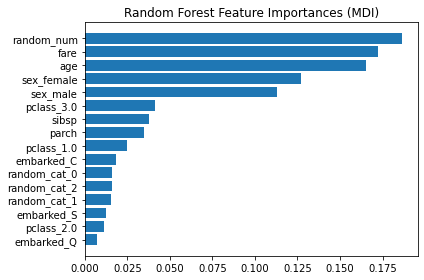

In [25]:
# noise로 삽입한 데이터가 제일 중요한 feature로 나옴
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

#### 검증 test 데이터로 permutation importance 수행
*  검증데이터로 permutation importance 수행하면 훈련데이터에서 noise데이터가 feature 중요하였는데

In [26]:
#  검증데이터로 permutation importance 수행하면 박스플롯으로 
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

ValueError: Input contains NaN

In [ ]:
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
model = GradientBoostingClassifier(random_state=1,validation_fraction=0.1,n_iter_no_change=20,subsample=0.25)

model.fit(X_train, y_train )
# perform permutation importance
results = permutation_importance(model, X_test, y_test, scoring='f1')
importance = results.importances_mean
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

In [ ]:
 # 결정트리에서 feature_importances_ # gridcv에는 없음
def Plot_permutation_importance(data_name, importance, indexs, model_name, time_name):
    # 한글깨짐 윈도우(window)
    font_name = mpl.font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name() # 폴더구분자 python / 임
    mpl.rc('font', family=font_name) # ahronbd.ttf
#     mpl.rcParams['font.family'] = 'NanumGothic'
#     mpl.rc('axes', unicode_minus=False)

    df = pd.Series(importance, index=indexs)
    df_20 = df.sort_values(ascending=False)#[:20]
    plt.figure(figsize=(8,6))
    sns.barplot(x=df_20, y=df_20.index)
    plt.title(f'{model_name} permutation_importance')
    plt.savefig(f"./imgSel/{data_name}_p_i_{model_name}_{time_name}.png", bbox_inches='tight') # dpi=100
#     plt.close(fig)
    plt.show() 
Plot_permutation_importance(data_name='project', importance=importance, indexs=X_train.columns, 
                             model_name='GradientBoostingClassifier', time_name='20201121-2200')